## Twiddle
Algorithm to find optimal PID gains.

In [1]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# You don't have to use the exact values as shown in the video
# play around with different values! This quiz isn't graded just see
# how low of an error you can get.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
#
# No cheating!
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

Final twiddle error = 3.562846420310725e-17


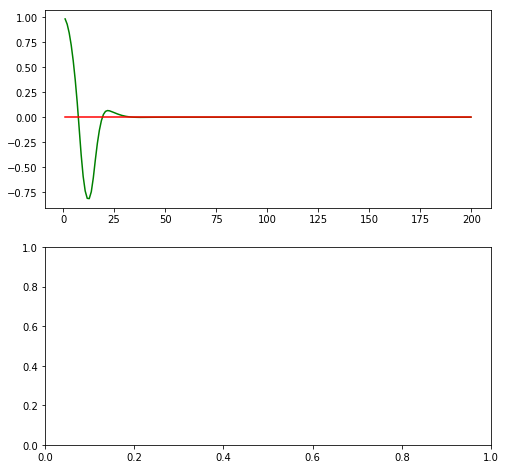

In [3]:
############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot


# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # Don't forget to call `make_robot` before every call of `run`!
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)
    # TODO: twiddle loop here
    while sum(dp)>0.00001:
        for i in range(len(p)):
            p[i]+=dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2*dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i]  += dp[i]
                    dp[i] *= 0.9
    
    return p, best_err


params, err = twiddle()
print("Final twiddle error = {}".format(err))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')